# Setup

In [8]:
# widen jupyter notebook window
from IPython.display import display, HTML
display(HTML("<style>.container {width:95% !important; }</style>"))

# check environment
import os
print(f'Conda Environment: ' + os.environ['CONDA_DEFAULT_ENV'])

from platform import python_version
print(f'python version: {python_version()}')

Conda Environment: ROICaT
python version: 3.9.13


In [9]:
import os
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import natsort

import torch

import gc
import time
import functools
import multiprocessing as mp


In [10]:
tic = time.time()
toc = {}
toc['start'] = time.time() - tic

In [11]:
%load_ext autoreload
%autoreload 2
import roicat
# from roicat import helpers, data_importing, ROInet
# from roicat.tracking import alignment, blurring, clustering, scatteringWaveletTransformer, similarity_graph, visualization

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
from bnpm import file_helpers

In [13]:
%matplotlib notebook

# Import paths

In [14]:
# dir_allOuterFolders = Path(r"/media/rich/bigSSD/other lab data/Harnett_lab/ROI_Tracking/Vincent_Valerio/4th_email/AllStatFiles/rbp16").resolve()
# dir_allOuterFolders = Path(r"/media/rich/bigSSD/res2p/scanimage data/round 5 experiments/mouse 2_6/just_stat_files").resolve()
# dir_allOuterFolders = str(Path(r"/media/rich/bigSSD/other lab data/Harvey_lab_ROIs/Sofia_ROIs/Data for Rich/SS33/").resolve())
dir_allOuterFolders = str(Path(r"/media/rich/bigSSD/downloads_tmp/loggers/mouse_g2FB/statFiles").resolve())

# folders_allSessions = natsort.natsorted(helpers.get_dir_contents(dir_allOuterFolders)[0])[:]

# dir_allS2pFolders = [dir_allOuterFolders / folder for folder in folders_allSessions]

pathSuffixToStat = 'stat.npy'
pathSuffixToOps = 'ops.npy'
# pathSuffixToStat = 'Slice02/stat.npy'
# pathSuffixToOps = 'Slice02/ops.npy'

# paths_allStat = np.array([path / pathSuffixToStat for path in dir_allS2pFolders])[:]
paths_allStat = test = roicat.helpers.find_paths(
    dir_outer=dir_allOuterFolders,
    reMatch=pathSuffixToStat,
    depth=4,
)
# paths_allOps  = np.array([path / pathSuffixToOps for path in dir_allS2pFolders])[:]
paths_allOps = test = roicat.helpers.find_paths(
    dir_outer=dir_allOuterFolders,
    reMatch=pathSuffixToOps,
    depth=4,
)
# paths_allStat = np.array([path / pathSuffixToStat for path in dir_allS2pFolders])
# paths_allOps  = np.array([path / pathSuffixToOps for path in dir_allS2pFolders])

# print(f'folder names of all sessions: \n{display(folders_allSessions)}')
print(f'paths to all stat files:');
[print(path) for path in paths_allStat];
print('');
print(f'paths to all ops files:');
[print(path) for path in paths_allOps];


paths to all stat files:
/media/rich/bigSSD/downloads_tmp/loggers/mouse_g2FB/statFiles/20221111/stat.npy
/media/rich/bigSSD/downloads_tmp/loggers/mouse_g2FB/statFiles/20221112/stat.npy
/media/rich/bigSSD/downloads_tmp/loggers/mouse_g2FB/statFiles/20221113/stat.npy
/media/rich/bigSSD/downloads_tmp/loggers/mouse_g2FB/statFiles/20221114/stat.npy
/media/rich/bigSSD/downloads_tmp/loggers/mouse_g2FB/statFiles/20221115/stat.npy
/media/rich/bigSSD/downloads_tmp/loggers/mouse_g2FB/statFiles/20221116/stat.npy
/media/rich/bigSSD/downloads_tmp/loggers/mouse_g2FB/statFiles/20221117/stat.npy
/media/rich/bigSSD/downloads_tmp/loggers/mouse_g2FB/statFiles/20221118/stat.npy

paths to all ops files:
/media/rich/bigSSD/downloads_tmp/loggers/mouse_g2FB/statFiles/20221111/ops.npy
/media/rich/bigSSD/downloads_tmp/loggers/mouse_g2FB/statFiles/20221112/ops.npy
/media/rich/bigSSD/downloads_tmp/loggers/mouse_g2FB/statFiles/20221113/ops.npy
/media/rich/bigSSD/downloads_tmp/loggers/mouse_g2FB/statFiles/20221114/op

In [15]:
toc['import_paths'] = time.time() - tic

# Import data

In [16]:
toc['import_data'] = time.time() - tic

In [17]:
data = roicat.data_importing.Data_suite2p(
    paths_statFiles=paths_allStat,
    paths_opsFiles=paths_allOps,
    um_per_pixel=2.0,
    new_or_old_suite2p='new',

    out_height_width=[36,36],
    
    type_meanImg='meanImgE',

    verbose=True,
)

assert data.check_completeness(verbose=False)['tracking'], f"Data object is missing attributes necessary for tracking."

Starting: Importing FOV images from ops files
Completed: Set FOV_height and FOV_width successfully.
Completed: Imported 8 FOV images.
Completed: Set FOV_images for 8 sessions successfully.
Importing spatial footprints from stat files.


100%|████████████████████████████████████████████████████████████████████████████████| 8/8 [00:07<00:00,  1.09it/s]


Imported 8 sessions of spatial footprints into sparse arrays.
Completed: Set spatialFootprints for 8 sessions successfully.
Completed: Created sessionID_concat.
Completed: Created centroids.
Staring: Creating centered ROI images from spatial footprints...
Completed: Created ROI images.


<IPython.core.display.Javascript object>


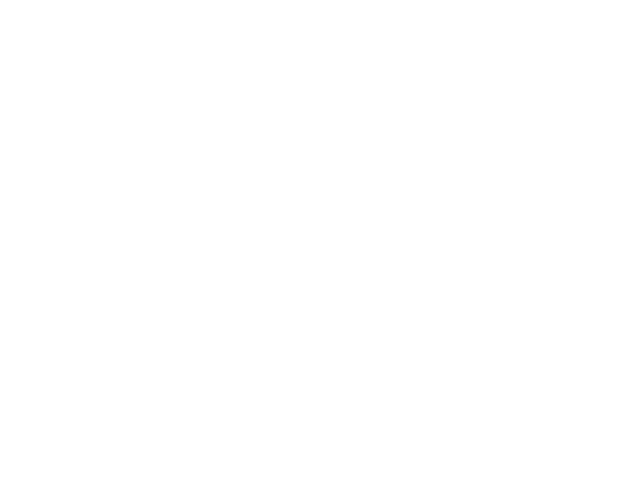

interactive(children=(IntSlider(value=0, description='i_frame', max=7), Output()), _dom_classes=('widget-inter…

<IPython.core.display.Javascript object>


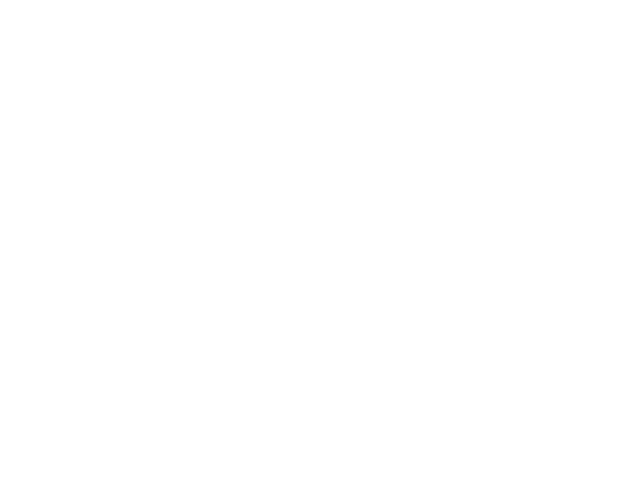

interactive(children=(IntSlider(value=0, description='i_frame', max=7), Output()), _dom_classes=('widget-inter…

<IPython.core.display.Javascript object>


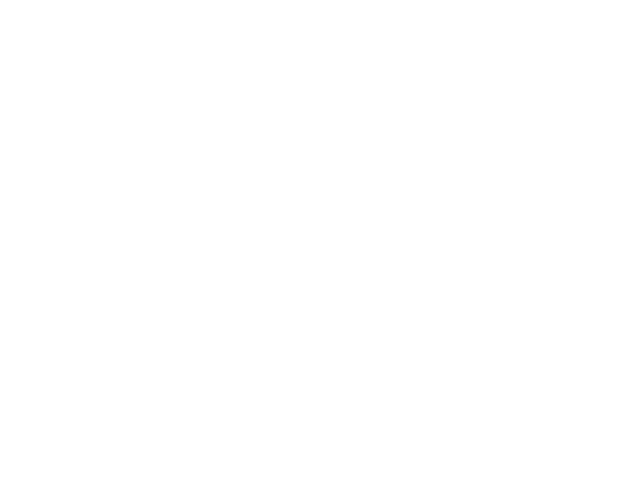

interactive(children=(IntSlider(value=0, description='i_frame', max=27744), Output()), _dom_classes=('widget-i…

In [18]:
%matplotlib notebook

roicat.tracking.visualization.display_toggle_image_stack(data.FOV_images)

roicat.tracking.visualization.display_toggle_image_stack([sf.max(0).reshape(data.FOV_height, data.FOV_width).toarray() for sf in data.spatialFootprints], clim=[0,0.1])

roicat.tracking.visualization.display_toggle_image_stack(np.concatenate(data.ROI_images, axis=0))

# Alignment

In [19]:
use_CLAHE = True
idx_session_template = 0.5
idx_st = int(idx_session_template * data.n_sessions) if type(idx_session_template) is float else idx_session_template

FOV_images = [roicat.tracking.alignment.clahe(im, grid_size=10, clipLimit=0, normalize=True) for im in data.FOV_images] if use_CLAHE else data.FOV_images

pcr = roicat.tracking.alignment.PhaseCorrelation_registration()

pcr.set_spectral_mask(
    freq_highPass=0.01,
    freq_lowPass=0.3,
    im_shape=(data.FOV_height, data.FOV_width)
)

pcr.register(
    template=FOV_images[idx_st],
    ims_moving=FOV_images,
    template_method='image',
);

aligner = roicat.tracking.alignment.Alinger(
    method='createOptFlow_DeepFlow',
    kwargs_method=None
)

aligner.register_ROIs(
    template=pcr.ims_registered[idx_st],
    FOVs=pcr.ims_registered,
    ROIs=data.spatialFootprints,
    template_method='image',
    shifts=pcr.shifts[:],
    return_sparse=True,
    normalize=True,
);

Finding optical flow fields between FOVs using image template...


100%|████████████████████████████████████████████████████████████████████████████████| 8/8 [00:04<00:00,  1.96it/s]


Registering ROIs...


100%|████████████████████████████████████████████████████████████████████████████████| 8/8 [02:50<00:00, 21.32s/it]


<IPython.core.display.Javascript object>


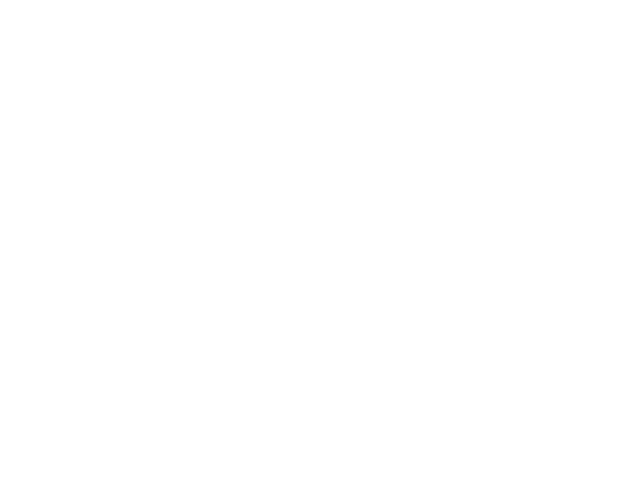

interactive(children=(IntSlider(value=0, description='i_frame', max=7), Output()), _dom_classes=('widget-inter…

<IPython.core.display.Javascript object>


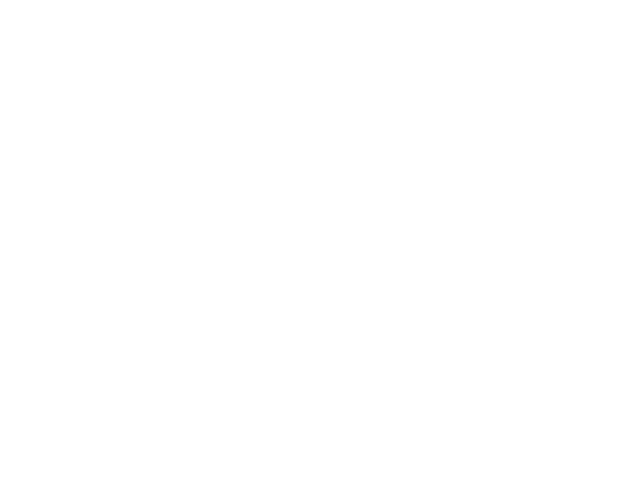

interactive(children=(IntSlider(value=0, description='i_frame', max=7), Output()), _dom_classes=('widget-inter…

<IPython.core.display.Javascript object>


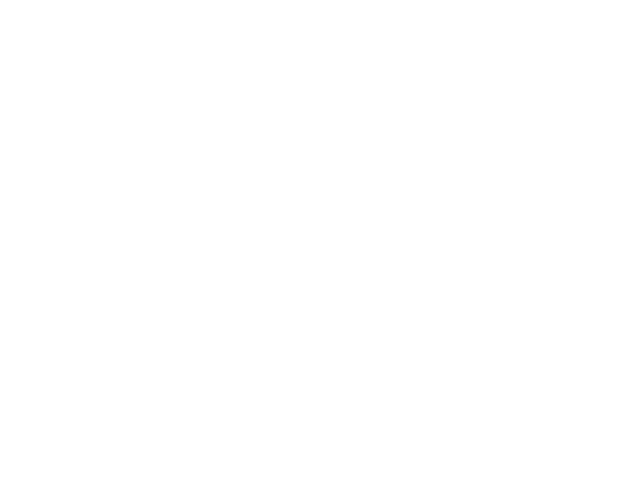

interactive(children=(IntSlider(value=0, description='i_frame', max=7), Output()), _dom_classes=('widget-inter…

<IPython.core.display.Javascript object>


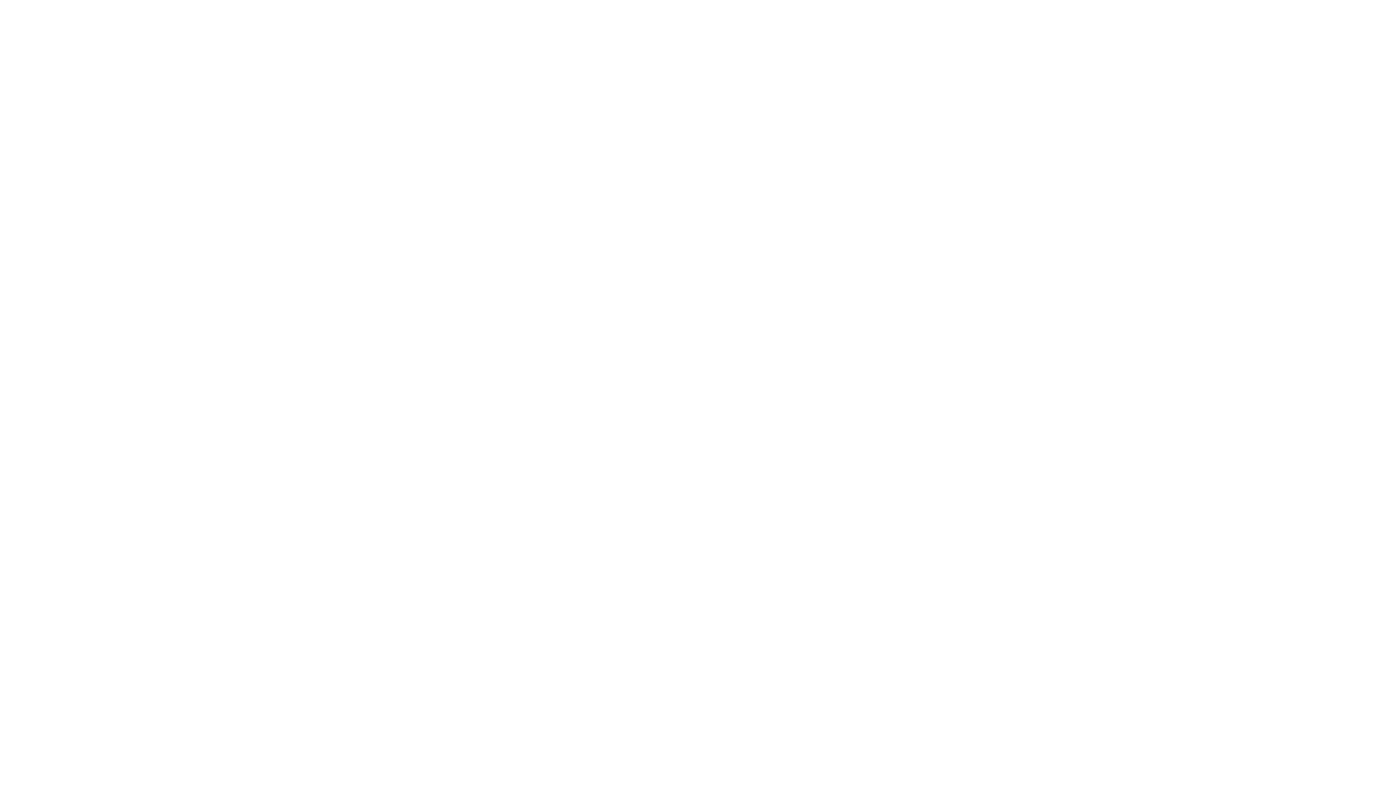

interactive(children=(IntSlider(value=0, description='i_frame', max=7), Output()), _dom_classes=('widget-inter…

In [20]:
%matplotlib notebook

roicat.tracking.visualization.display_toggle_image_stack(pcr.ims_registered[:])

roicat.tracking.visualization.display_toggle_image_stack(aligner.FOVs_aligned)
roicat.tracking.visualization.display_toggle_image_stack(aligner.get_ROIsAligned_maxIntensityProjection(), clim=[0,0.03])
roicat.tracking.visualization.display_toggle_2channel_image_stack(aligner.flows)

In [21]:
toc['alignment'] = time.time() - tic

## Blur ROIs (optional)

In [22]:
blurrer = roicat.tracking.blurring.ROI_Blurrer(
    frame_shape=(data.FOV_height, data.FOV_width),
    kernel_halfWidth=2,
    plot_kernel=False,
)

blurrer.blur_ROIs(
    spatialFootprints=aligner.ROIs_aligned[:],
)

Preparing the Toeplitz convolution matrix
Performing convolution for blurring


<IPython.core.display.Javascript object>


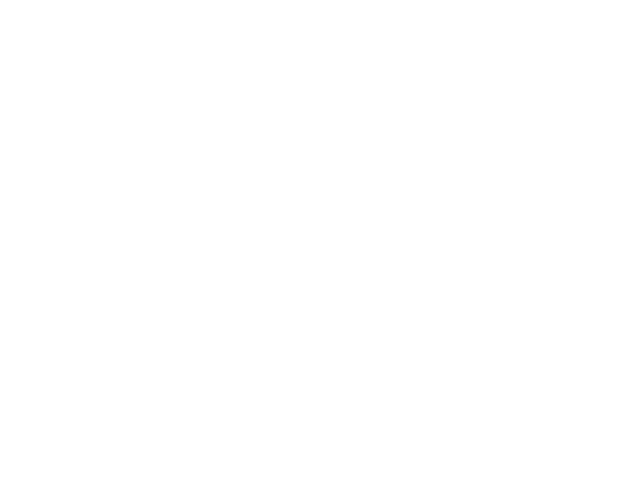

interactive(children=(IntSlider(value=0, description='i_frame', max=7), Output()), _dom_classes=('widget-inter…

In [23]:
%matplotlib notebook
roicat.tracking.visualization.display_toggle_image_stack(blurrer.get_ROIsBlurred_maxIntensityProjection())

In [24]:
toc['blur'] = time.time() - tic

## Neural network embedding distances

In [25]:
roinet = roicat.ROInet.ROInet_embedder(
    device='cuda:0',
    dir_networkFiles=r'/home/rich/Desktop/tmp_data/',
    download_method='check_local_first',
    download_url='https://osf.io/pkc2x/download',
    download_hash='1e62893d8e944819516e793656afc31d',
    forward_pass_version='latent',
    verbose=True,
)

File already exists locally: /home/rich/Desktop/tmp_data/ROInet.zip
Hash of local file matches provided hash_hex.
Extracting /home/rich/Desktop/tmp_data/ROInet.zip to /home/rich/Desktop/tmp_data.
Completed zip extraction.
Imported model from /home/rich/Desktop/tmp_data/ROInet_tracking_20220527/model.py
Loaded params_model from /home/rich/Desktop/tmp_data/ROInet_tracking_20220527/params.json


/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/ROICaT/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/ROICaT/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Tiny_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Generated network using params_model
Loaded state_dict into network from /home/rich/Desktop/tmp_data/ROInet_tracking_20220527/ConvNext_tiny__1_0_unfrozen__simCLR.pth
Loaded network onto device cuda:0


In [26]:
roinet.generate_dataloader(
    ROI_images=data.ROI_images,
    um_per_pixel=data.um_per_pixel,
    pref_plot=False,
    
    batchSize_dataloader=8,
    pinMemory_dataloader=True,
    numWorkers_dataloader=mp.cpu_count(),
    persistentWorkers_dataloader=True,
    prefetchFactor_dataloader=2,    

#     batchSize_dataloader=1,
#     pinMemory_dataloader=False,
#     numWorkers_dataloader=0,
#     persistentWorkers_dataloader=False,
#     prefetchFactor_dataloader=2,    
);

Starting: resizing ROIs
Completed: resizing ROIs
Defined image transformations: Sequential(
  (0): ScaleDynamicRange(scaler_bounds=(0, 1))
  (1): Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
  (2): TileChannels(dim=0)
)
Defined dataset
Defined dataloader


<IPython.core.display.Javascript object>


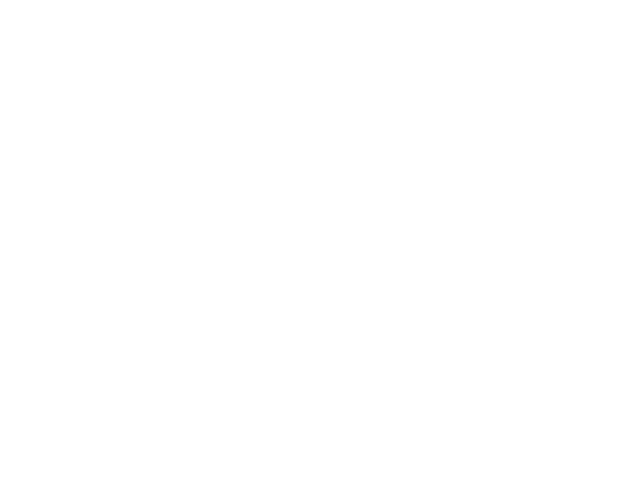

interactive(children=(IntSlider(value=0, description='i_frame', max=27744), Output()), _dom_classes=('widget-i…

In [27]:
%matplotlib notebook
roicat.tracking.visualization.display_toggle_image_stack(roinet.ROI_images_rs)

In [28]:
roinet.generate_latents();


starting: running data through network


  0%|                                                                                     | 0/3469 [00:00<?, ?it/s]/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/ROICaT/lib/python3.9/site-packages/torch/nn/modules/module.py:1130: UserWarning: operator() profile_node %247 : int = prim::profile_ivalue(%out_dtype.1)
 does not have profile information (Triggered internally at  ../torch/csrc/jit/codegen/cuda/graph_fuser.cpp:104.)
  return forward_call(*input, **kwargs)
/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/ROICaT/lib/python3.9/site-packages/torch/nn/modules/module.py:1130: UserWarning: operator() profile_node %247 : int = prim::profile_ivalue(%out_dtype.1)
 does not have profile information (Triggered internally at  ../torch/csrc/jit/codegen/cuda/graph_fuser.cpp:104.)
  return forward_call(*input, **kwargs)
/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/ROICaT/lib/python3.9/site-packages/torch/nn/modules/module.py:1130: UserWarning: o

/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/ROICaT/lib/python3.9/site-packages/torch/nn/modules/module.py:1130: UserWarning: operator() profile_node %247 : int = prim::profile_ivalue(%out_dtype.1)
 does not have profile information (Triggered internally at  ../torch/csrc/jit/codegen/cuda/graph_fuser.cpp:104.)
  return forward_call(*input, **kwargs)
/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/ROICaT/lib/python3.9/site-packages/torch/nn/modules/module.py:1130: UserWarning: operator() profile_node %247 : int = prim::profile_ivalue(%out_dtype.1)
 does not have profile information (Triggered internally at  ../torch/csrc/jit/codegen/cuda/graph_fuser.cpp:104.)
  return forward_call(*input, **kwargs)
/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/ROICaT/lib/python3.9/site-packages/torch/nn/modules/module.py:1130: UserWarning: operator() profile_node %247 : int = prim::profile_ivalue(%out_dtype.1)
 does not have profile information (Triggere

completed: running data through network


In [29]:
gc.collect()
torch.cuda.empty_cache()
gc.collect()
torch.cuda.empty_cache()

In [30]:
toc['NN'] = time.time() - tic

## Scattering wavelet embedding distances

In [31]:
swt = roicat.tracking.scatteringWaveletTransformer.SWT(
    kwargs_Scattering2D={'J': 2, 'L': 2}, 
    image_shape=data.ROI_images[0].shape[1:3], 
    device='cuda:0'
)

swt.transform(
    ROI_images=np.concatenate(data.ROI_images, axis=0),
    batch_size=100,
);

SWT initialized
Starting: SWT transform on ROIs


278it [00:00, 357.43it/s]                                                                                          

Completed: SWT transform on ROIs


In [32]:
gc.collect()
torch.cuda.empty_cache()
gc.collect()
torch.cuda.empty_cache()


In [33]:
toc['SWT'] = time.time() - tic

## Compute similarities

<IPython.core.display.Javascript object>


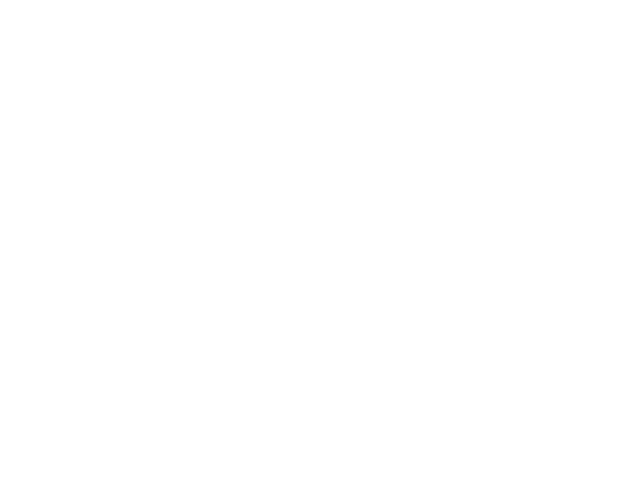

Computing pairwise similarity between ROIs...


100%|██████████████████████████████████████████████████████████████████████████████| 32/32 [00:07<00:00,  4.00it/s]


Joining blocks into full similarity matrices...
Joining s_sf...


7698it [00:06, 1282.87it/s]                                                                                        


Joining s_NN...


7698it [00:06, 1282.20it/s]                                                                                        


Joining s_SWT...


7698it [00:06, 1280.68it/s]                                                                                        


Joining s_sesh...


7698it [00:06, 1234.34it/s]                                                                                        


In [34]:
sim = roicat.tracking.similarity_graph.ROI_graph(
    n_workers=-1,
    frame_height=data.FOV_height,
    frame_width=data.FOV_width,
#     block_height=data.FOV_height,
#     block_width=data.FOV_width,
    block_height=128,
    block_width=128,
    algorithm_nearestNeigbors_spatialFootprints='brute',
    verbose=True,
)

sim.visualize_blocks()

s_sf, s_NN, s_SWT, s_sesh = sim.compute_similarity_blockwise(
    spatialFootprints=blurrer.ROIs_blurred,
#     spatialFootprints=aligner.ROIs_aligned,
    features_NN=roinet.latents,
    features_SWT=swt.latents,
    ROI_session_bool=data.sessionID_concat,
    spatialFootprint_maskPower=1.0,
);

In [35]:
sim.make_normalized_similarities(
    centers_of_mass=data.centroids,
    features_NN=roinet.latents,
    features_SWT=swt.latents,
#     features_SWT=None,
    k_max=4000,
    k_min=100,
    algo_NN='kd_tree',
    device='cuda:0'
)

toc['sim'] = time.time() - tic

Finding k-range of center of mass distance neighbors for each ROI...
Normalizing Neural Network similarity scores...


100%|█████████████████████████████████████████████████████████████████████| 27745/27745 [00:02<00:00, 12778.40it/s]


Normalizing SWT similarity scores...


100%|██████████████████████████████████████████████████████████████████████| 27745/27745 [00:02<00:00, 9779.23it/s]


# Clustering

Finding mixing parameters using automated hyperparameter tuning...
Best value found: 0.06921546161174774 with parameters {'power_SF': 1.5770894371258108, 'power_NN': 0.8784972978029348, 'power_SWT': 0.26615323599021984, 'p_norm': 0.6336827323223799, 'sig_SF_kwargs': None, 'sig_NN_kwargs': {'mu': 0.0037694209982618676, 'b': 0.488099246766147}, 'sig_SWT_kwargs': {'mu': 0.21784624530781702, 'b': 0.06909156635355979}}


<IPython.core.display.Javascript object>


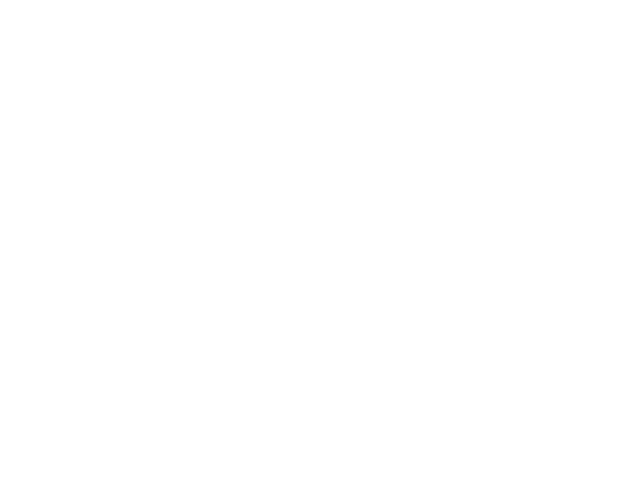

<IPython.core.display.Javascript object>


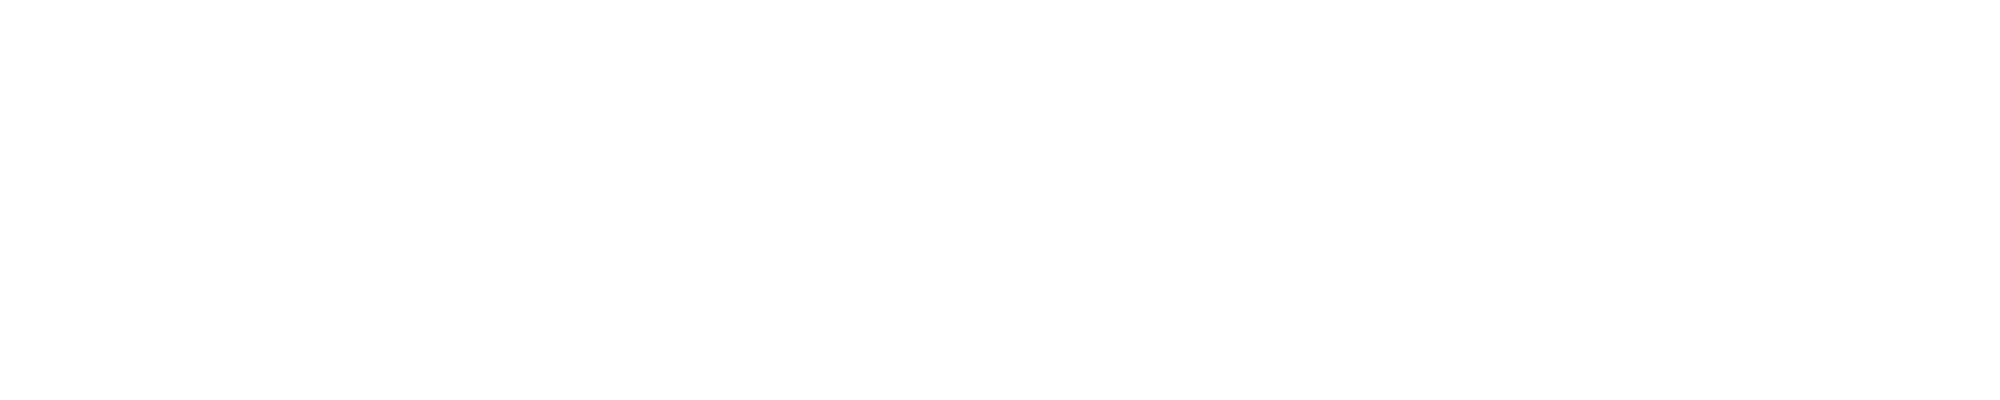

In [36]:
clusterer = roicat.tracking.clustering.Clusterer(
    s_sf=sim.s_sf,
    s_NN_z=sim.s_NN_z,
    s_SWT_z=sim.s_SWT_z,
    s_sesh=sim.s_sesh,
)

kwargs_makeConjunctiveDistanceMatrix_best = clusterer.find_optimal_parameters_for_pruning(
    n_bins=50,
    find_parameters_automatically=True,
    kwargs_findParameters={
        'n_patience': 100,
        'tol_frac': 0.05,
        'max_trials': 350,
        'max_duration': 60*10,
        'verbose': False,
    },
    bounds_findParameters={
        'power_SF': (0.3, 2),
        'power_NN': (0.2, 2),
        'power_SWT': (0.1, 1),
        'p_norm': (-5, 5),
        'sig_NN_kwargs_mu': (0, 0.5),
        'sig_NN_kwargs_b': (0.05, 2),
        'sig_SWT_kwargs_mu': (0, 0.5),
        'sig_SWT_kwargs_b': (0.05, 2),
    },
    n_jobs_findParameters=-1,    
#     fallback_d_cutoff=0.5,
#     plot_pref=True,
)

toc['separate_diffSame'] = time.time() - tic

clusterer.plot_distSame()

clusterer.plot_similarity_relationships(
    plots_to_show=[1,2,3], 
    max_samples=100000, 
    kwargs_scatter={'s':1, 'alpha':0.2},
    kwargs_makeConjunctiveDistanceMatrix=kwargs_makeConjunctiveDistanceMatrix_best,
#     kwargs_makeConjunctiveDistanceMatrix={
#         'power_SF': 1.0,
#         'power_NN': 1.0,
#         'power_SWT': 0.1,
#         'p_norm': -4.0,
#         'sig_SF_kwargs': {'mu':0.5, 'b':4},
# #         'sig_SF_kwargs': None,
#         'sig_NN_kwargs': {'mu':0.5, 'b':1.5},
#         'sig_SWT_kwargs': {'mu':0.5, 'b':0.5},
#     },
);

In [37]:
clusterer.make_pruned_similarity_graphs(
    d_cutoff=None,
    kwargs_makeConjunctiveDistanceMatrix=kwargs_makeConjunctiveDistanceMatrix_best
)

/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/ROICaT/lib/python3.9/site-packages/scipy/sparse/_index.py:146: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [38]:
if data.n_sessions >= 8:
    labels = clusterer.fit(
        session_bool=data.sessionID_concat,
        min_cluster_size=2,
        cluster_selection_method='leaf',
        d_clusterMerge=None,
        alpha=0.999,
        n_iter_violationCorrection=6,
        d_conj=None,
        kwargs_makeConjunctiveDistanceMatrix=kwargs_makeConjunctiveDistanceMatrix_best,
    #     kwargs_makeConjunctiveDistanceMatrix={
    #         'power_SF': 1.0,
    #         'power_NN': 1.0,
    #         'power_SWT': 0.1,
    #         'p_norm': -2,
    #         'sig_SF_kwargs': None,
    #         'sig_NN_kwargs':  {'mu':0, 'b':0.2},
    #         'sig_SWT_kwargs': {'mu':0, 'b':0.2},
    #     },
        split_intraSession_clusters=True,
        discard_failed_pruning=True,
        d_step=0.01,
    )

else:
    labels = clusterer.fit_sequentialHungarian(
        session_bool=data.sessionID_concat,
        thresh_cost=0.6,
        d_conj=None,
        kwargs_makeConjunctiveDistanceMatrix=kwargs_makeConjunctiveDistanceMatrix_best,
    #     kwargs_makeConjunctiveDistanceMatrix={
    #     'power_SF': 1.0,
    #     'power_NN': 1.0,
    #     'power_SWT': 0.1,
    #     'p_norm': -2,
    #     'sig_SF_kwargs': None,
    #     'sig_NN_kwargs':  {'mu':0, 'b':0.2},
    #     'sig_SWT_kwargs': {'mu':0, 'b':0.2},
    #     },
    )

labels_bySession = [labels[idx] for idx in data.sessionID_concat.T]

Fitting with HDBSCAN and splitting clusters with multiple ROIs per session


  0%|                                                                                        | 0/6 [00:00<?, ?it/s]/media/rich/OS/Users/Richard/Linux_stuff_on_OS/conda_envs/envs/ROICaT/lib/python3.9/site-packages/scipy/sparse/_index.py:137: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray_sparse(i, j, x)
100%|████████████████████████████████████████████████████████████████████████████████| 6/6 [02:33<00:00, 25.53s/it]


In [39]:
## results_clustering
print(f'Number of clusters: {len(np.unique(labels))}')
print(f'Number of discarded ROIs: {(labels==-1).sum()}')

Number of clusters: 4739
Number of discarded ROIs: 4397


In [40]:
toc['clustering'] = time.time() - tic

# Visualize results

In [41]:
FOV_clusters = roicat.tracking.visualization.compute_colored_FOV(
    spatialFootprints=[r.power(0.7) for r in aligner.ROIs_aligned],
    FOV_height=data.FOV_height,
    FOV_width=data.FOV_width,
    boolSessionID=data.sessionID_concat,
    labels=labels,
    confidence=None,
)

<IPython.core.display.Javascript object>


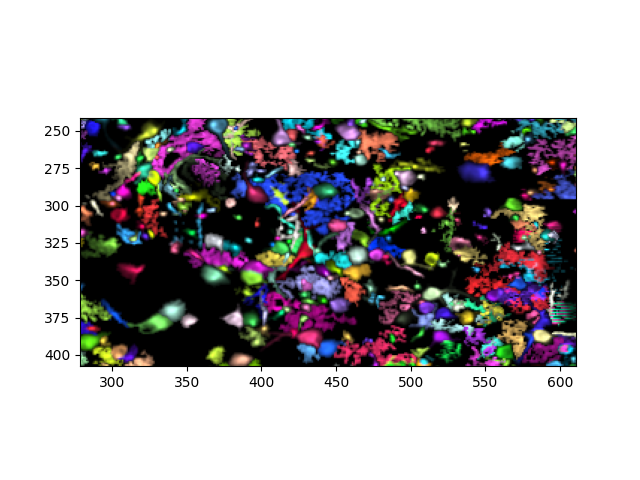

interactive(children=(IntSlider(value=0, description='i_frame', max=7), Output()), _dom_classes=('widget-inter…

In [51]:
%matplotlib notebook
roicat.tracking.visualization.display_toggle_image_stack(
    FOV_clusters, 
#     interpolation='none', 
#     filternorm=False, 
#     resample=False
)

In [43]:
# visualization.display_toggle_image_stack(aligner.get_ROIsAligned_maxIntensityProjection())

/tmp/ipykernel_1746444/3994115036.py:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(40,1))


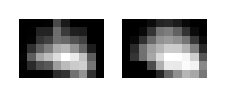

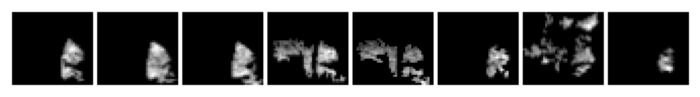

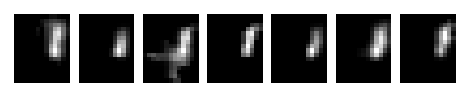

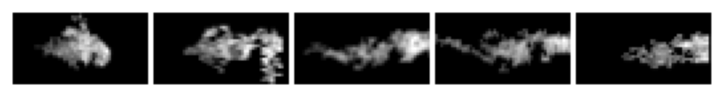

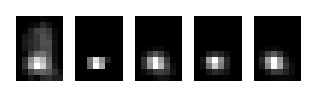

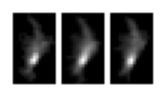

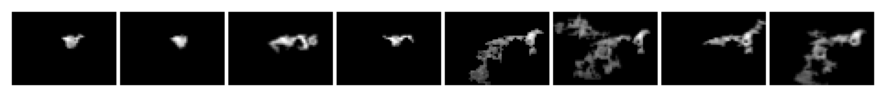

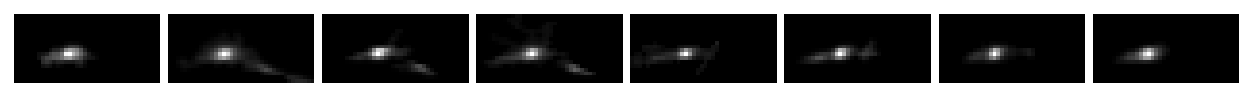

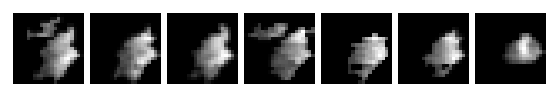

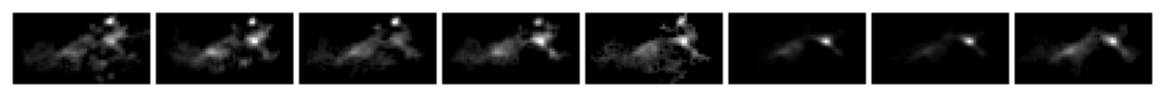

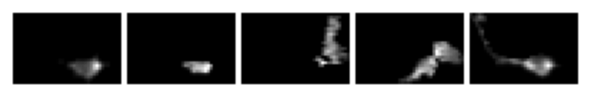

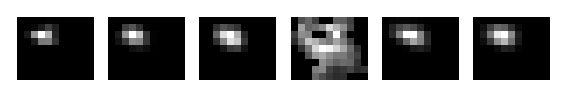

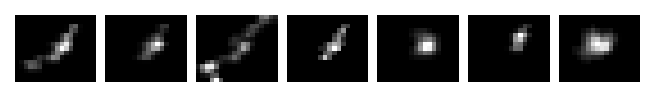

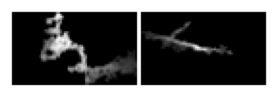

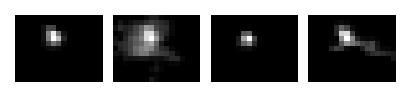

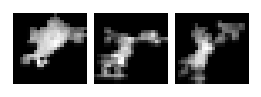

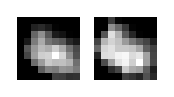

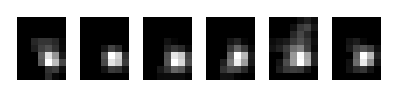

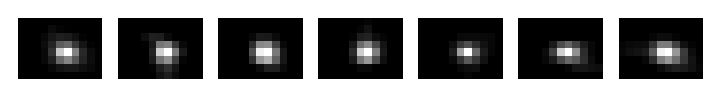

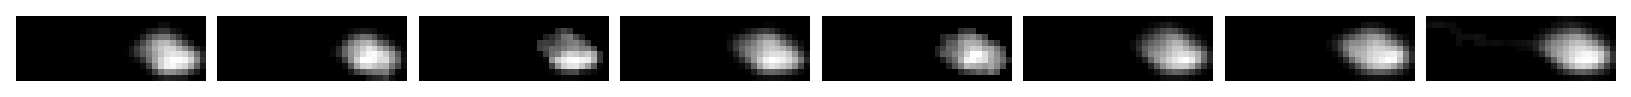

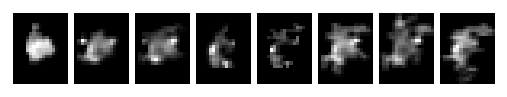

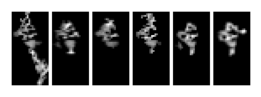

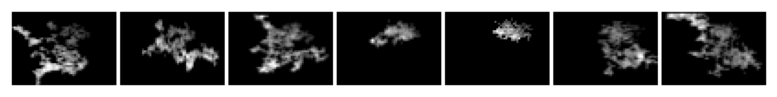

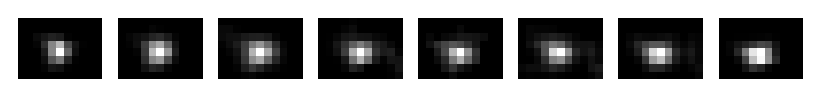

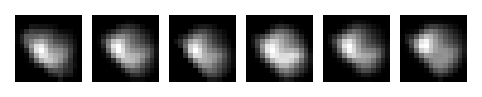

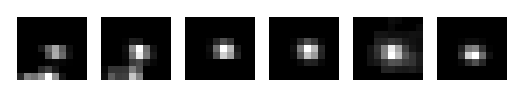

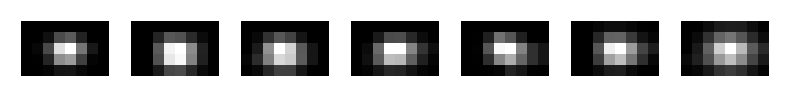

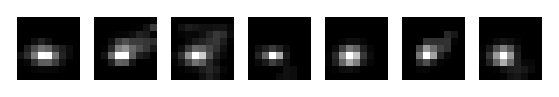

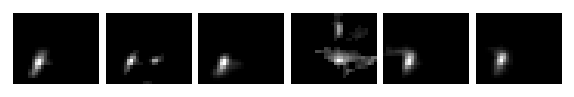

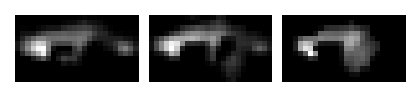

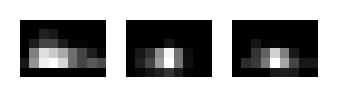

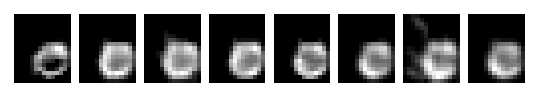

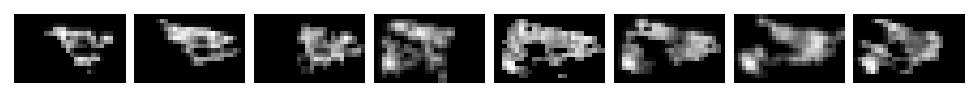

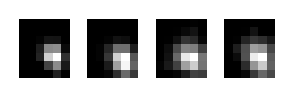

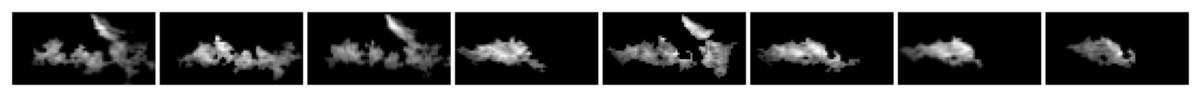

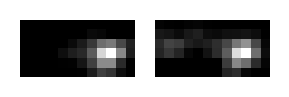

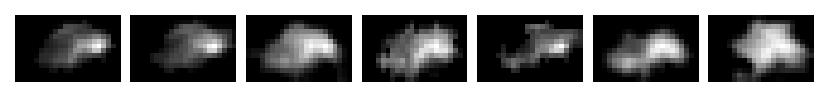

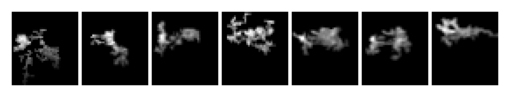

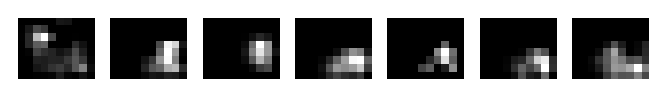

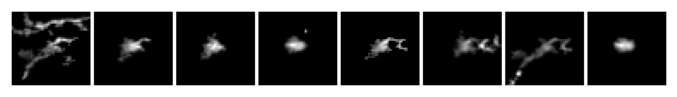

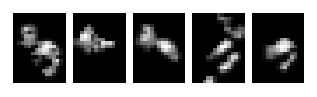

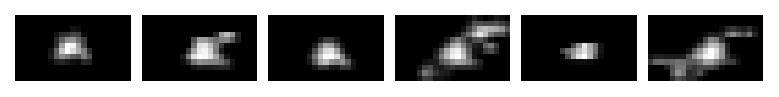

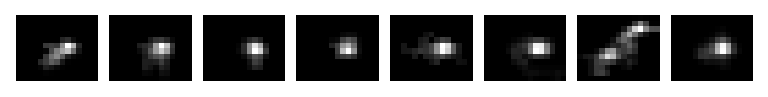

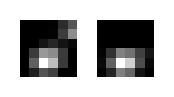

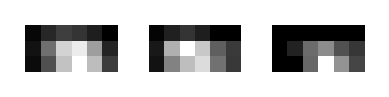

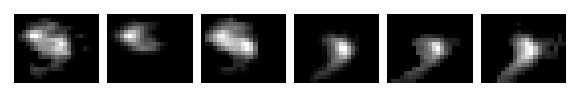

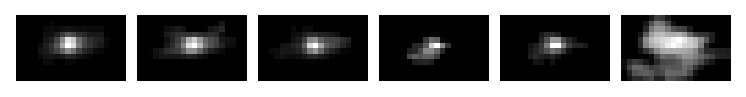

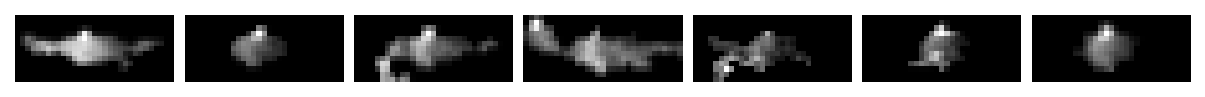

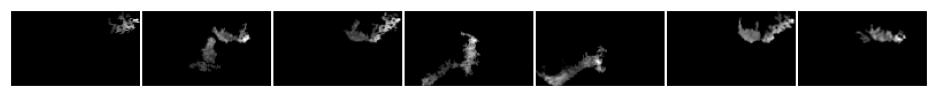

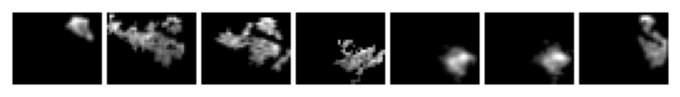

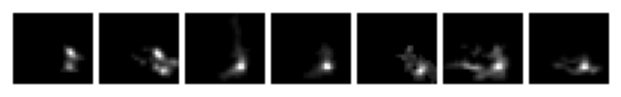

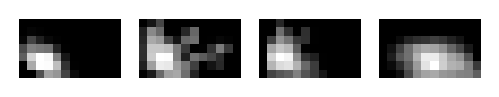

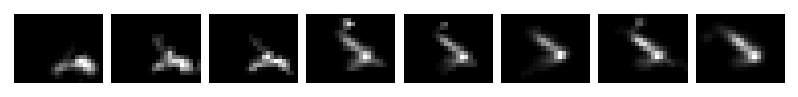

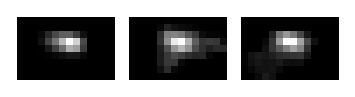

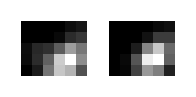

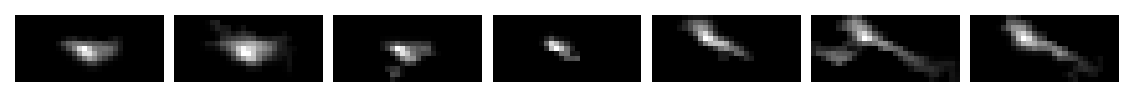

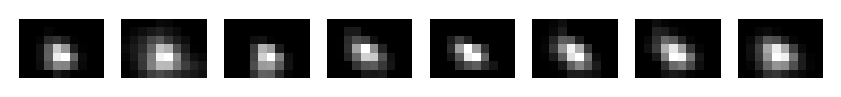

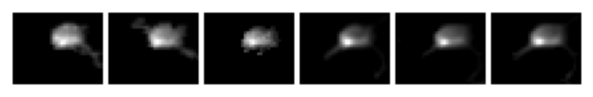

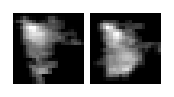

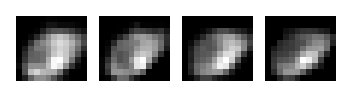

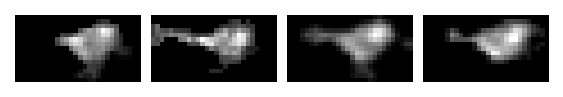

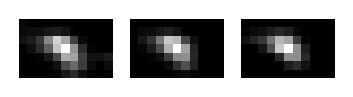

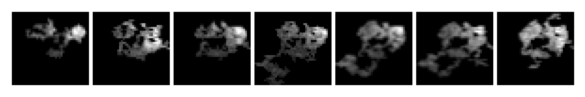

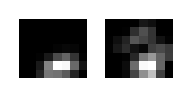

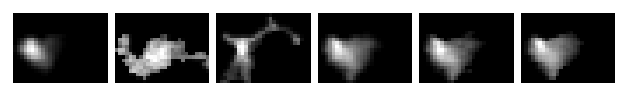

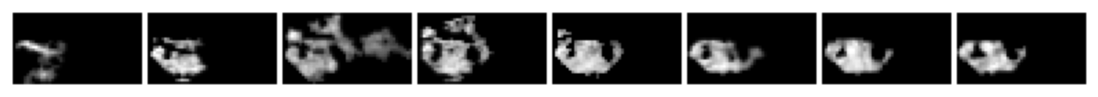

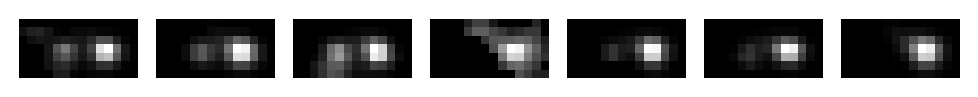

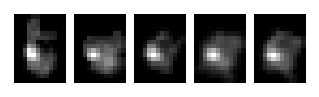

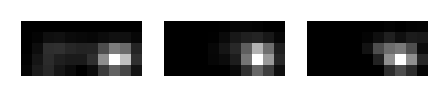

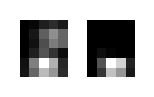

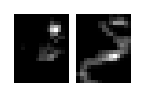

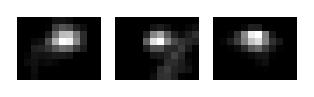

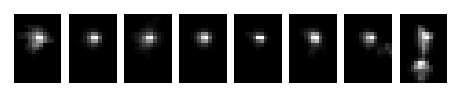

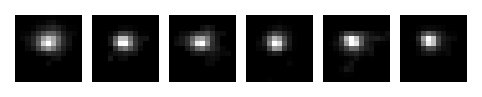

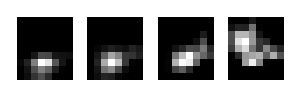

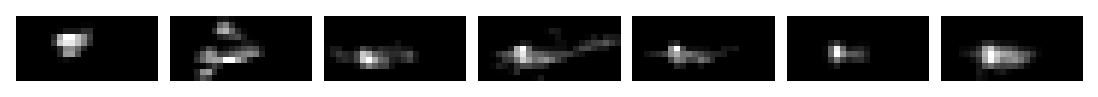

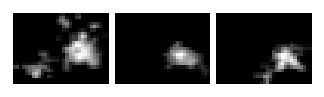

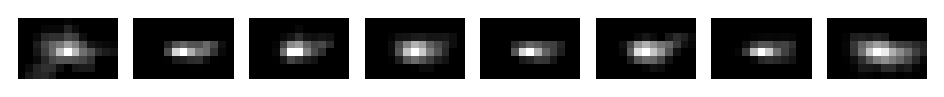

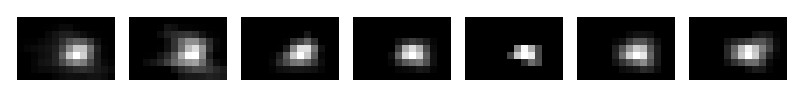

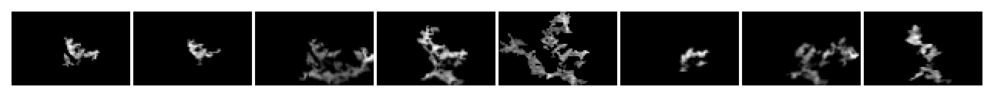

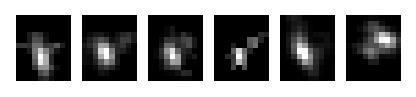

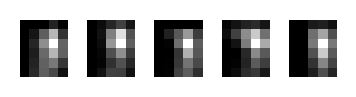

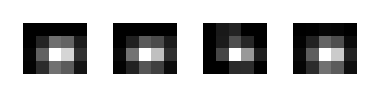

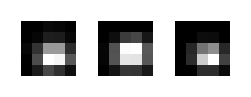

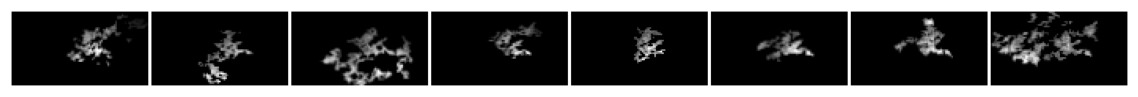

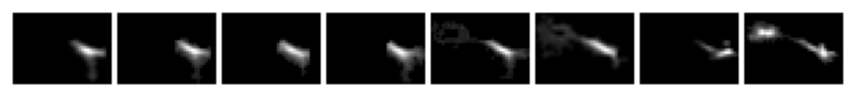

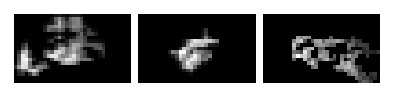

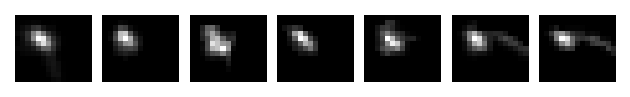

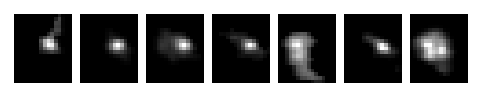

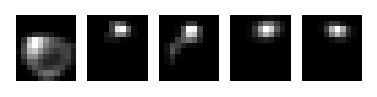

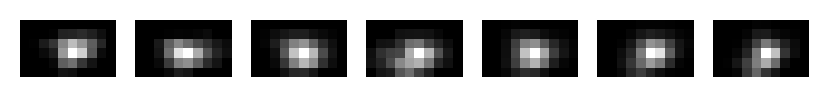

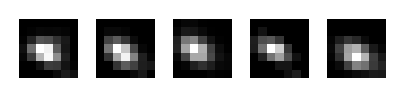

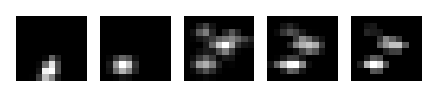

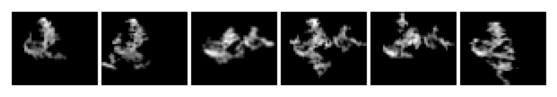

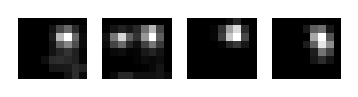

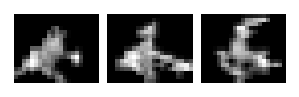

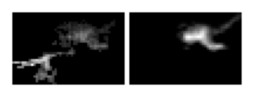

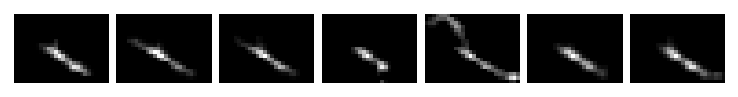

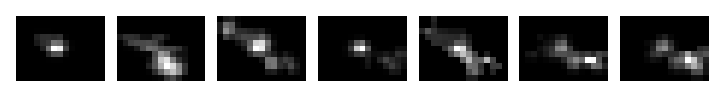

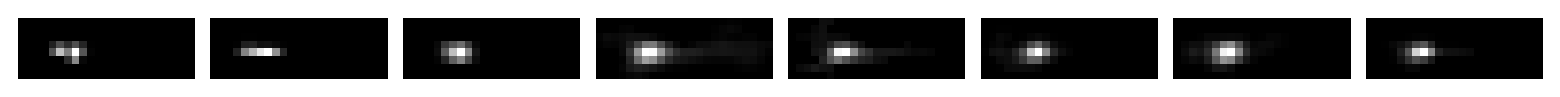

In [44]:
import scipy.sparse

ucids = labels.copy()
# ucids = ucids[ucids==975]
ucids_unique = np.unique(ucids[ucids>-1])

# ROI_ims = np.concatenate(data.ROI_images, axis=0)
ROI_ims_sparse = scipy.sparse.vstack(aligner.ROIs_aligned)
ROI_ims_sparse = ROI_ims_sparse.multiply( ROI_ims_sparse.max(1).power(-1) ).tocsr()


ucid_sfCat = []
for ucid in ucids_unique:
    idx = np.where(ucids == ucid)[0]
    ucid_sfCat.append( np.concatenate(list(roicat.tracking.visualization.crop_cluster_ims(ROI_ims_sparse[idx].toarray().reshape(len(idx), data.FOV_height, data.FOV_width))), axis=1) )
#     ucid_sfCat.append( np.concatenate(list(ROI_ims_sparse[idx].toarray().reshape(len(idx), data.FOV_height, data.FOV_width)), axis=1) )
# data.ROI_images[i_sesh][idx] for 


%matplotlib inline

for sf in ucid_sfCat[:100]:
    plt.figure(figsize=(40,1))
    plt.imshow(sf, cmap='gray')
    plt.axis('off')

<IPython.core.display.Javascript object>


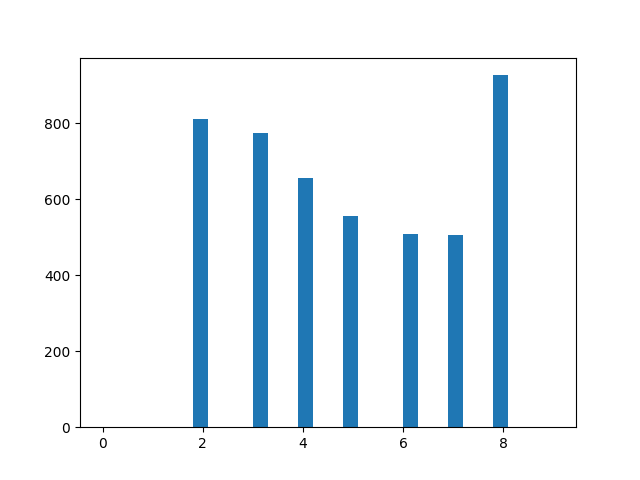

In [45]:
%matplotlib notebook

_, counts = np.unique(labels, return_counts=True)

plt.figure()
plt.hist(counts, 30, range=(0, data.n_sessions+1));


In [46]:
toc['visualize'] = time.time() - tic

# Save results

In [47]:
dir_save = Path('/home/rich/Desktop/').resolve()
# name_save = Path(dir_allOuterFolders).resolve().name
name_save = 'mouse_g2FB'
path_save = dir_save / (name_save + '.ROICaT.results' + '.pkl')
print(f'path_save: {path_save}')

path_save: /home/rich/Desktop/mouse_g2FB.ROICaT.results.pkl


In [48]:
ROIs = {
    "ROIs_aligned": aligner.ROIs_aligned,
    "ROIs_raw": data.spatialFootprints,
    "frame_height": data.FOV_height,
    "frame_width": data.FOV_width,
    "idx_roi_session": np.where(data.sessionID_concat)[1]
}

results = {
    "UCIDs": labels,
    "UCIDs_bySession": labels_bySession,
    "ROIs": ROIs,
    "input_data": {
        "paths_stat": data.paths_stat,
        "paths_ops": data.paths_ops,
    }
}

roicat.helpers.pickle_save(
    obj=results,
    path_save=path_save,
    mkdir=True,
)

In [49]:
toc['saving'] = time.time() - tic

In [50]:
toc

{'start': 3.9577484130859375e-05,
 'import_paths': 0.33162736892700195,
 'import_data': 0.39662837982177734,
 'alignment': 189.39028072357178,
 'blur': 190.56622457504272,
 'NN': 236.6315143108368,
 'SWT': 238.05147314071655,
 'sim': 298.48768615722656,
 'separate_diffSame': 304.80680227279663,
 'clustering': 465.10864448547363,
 'visualize': 490.9594838619232,
 'saving': 491.19472193717957}

In [33]:
import sys
sys.path.append('/media/rich/Home_Linux_partition/github_repos/')

In [29]:
from bnpm import path_helpers, file_helpers

In [47]:
import scipy

In [23]:
mouse_name = 'SS40'

In [54]:
paths_labelsDict = path_helpers.find_paths(
    dir_outer='/media/rich/bigSSD/other lab data/Harvey_lab_ROIs/Sofia_ROIs/Data for Rich/' + mouse_name,
    reMatch='Slice02/labels_dict.npy',
    depth=4,
)

In [55]:
path_roicatResults = path_helpers.find_paths(
    dir_outer='/home/rich/Desktop/',
    reMatch=mouse_name + '.' + 'Slice02',
    depth=1,
)

In [56]:
roicat_results = file_helpers.pickle_load(path_roicatResults[0])

In [57]:
roicat_results.keys()

dict_keys(['UCIDs', 'UCIDs_bySession', 'ROIs', 'params', 'runTimes'])

In [58]:
n_roi_per_session = [len(r) for r in roicat_results['UCIDs_bySession']]

In [59]:
labels_sofia_files = [np.load(p, allow_pickle=True)[()] for p in paths_labelsDict]

labels_sofia = [{key: np.array([l[key] for l in ls]) for key in ['source_indx', 'source_id_sia']} for ls in labels_sofia_files]

ucids_bySession_gt = [np.ones(n, dtype=int)*-1 for n in n_roi_per_session]

for ii in range(len(ucids_bySession_gt)):
    if len(labels_sofia[ii]['source_indx']) > 0:
        ucids_bySession_gt[ii][labels_sofia[ii]['source_indx']-1] = labels_sofia[ii]['source_id_sia']

ucids_cat_sofia = np.concatenate(ucids_bySession_gt)

u, c = np.unique(ucids_cat_sofia, return_counts=True)
ucids_cat_sofia[np.isin(ucids_cat_sofia, u[c==1])] = -1

In [60]:
roicat_results['ROIs'].keys()

dict_keys(['ROIs_aligned', 'ROIs_raw', 'frame_height', 'frame_width', 'idx_roi_session'])

In [73]:
FOV_clusters = visualization.compute_colored_FOV(
    spatialFootprints=[r.power(0.7) for r in roicat_results['ROIs']['ROIs_aligned']],
    FOV_height=roicat_results['ROIs']['frame_height'],
    FOV_width=roicat_results['ROIs']['frame_width'],
    labels=ucids_bySession_gt,
    boolSessionID=None,
    confidence=None,
)

<IPython.core.display.Javascript object>


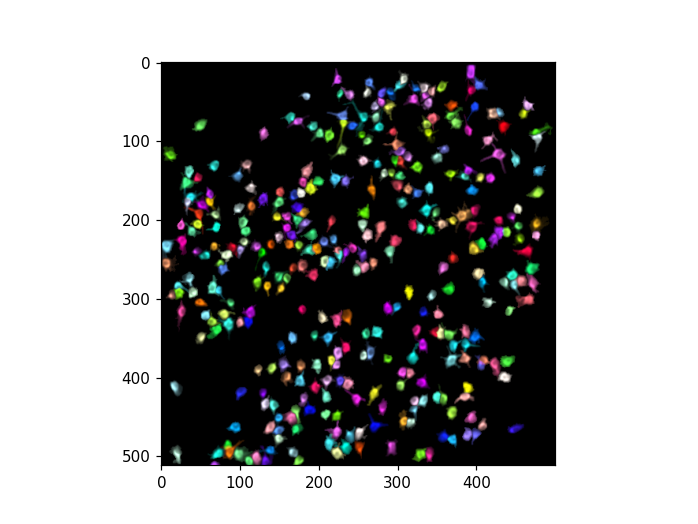

interactive(children=(IntSlider(value=0, description='i_frame', max=30), Output()), _dom_classes=('widget-inte…

In [72]:
%matplotlib notebook
visualization.display_toggle_image_stack(
    FOV_clusters, 
#     interpolation='none', 
#     filternorm=False, 
#     resample=False
)

In [74]:
clustering.score_labels(
    labels_test=labels,
    labels_true=ucids_cat_sofia,
    ignore_negOne=True,
    compute_mutual_info=True
)

NameError: name 'labels' is not defined

In [16]:
from bnpm import path_helpers

In [17]:
paths_noah = path_helpers.find_paths('/home/rich/Desktop/', reMatch='sweep')

In [18]:
paths_noah

['/home/rich/Desktop/sweep_14.p',
 '/home/rich/Desktop/sweep_79.p',
 '/home/rich/Desktop/sweep_170.p',
 '/home/rich/Desktop/sweep_190.p']

In [19]:
test = file_helpers.pickle_load(paths_noah[0])

In [20]:
test.keys()

dict_keys(['params', 'cluster_output', 'A', 'templates', 'assignments', 'matchings', 'n_reg', 'assignments_filtered', 'spatial_filtered'])

In [21]:
test['cluster_output']

[[0,
  -1,
  2,
  -1,
  -1,
  -1,
  -1,
  7,
  -1,
  -1,
  -1,
  -1,
  12,
  13,
  14,
  -1,
  16,
  -1,
  -1,
  -1,
  -1,
  21,
  -1,
  23,
  24,
  -1,
  -1,
  -1,
  -1,
  29,
  30,
  31,
  -1,
  33,
  -1,
  35,
  36,
  37,
  -1,
  -1,
  40,
  41,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  60,
  -1,
  -1,
  -1,
  64,
  65,
  66,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  73,
  -1,
  -1,
  -1,
  -1,
  78,
  -1,
  -1,
  -1,
  -1,
  83,
  -1,
  -1,
  -1,
  87,
  -1,
  89,
  90,
  -1,
  92,
  -1,
  94,
  -1,
  -1,
  97,
  -1,
  99,
  -1,
  -1,
  -1,
  103,
  104,
  105,
  -1,
  107,
  -1,
  -1,
  110,
  111,
  -1,
  113,
  114,
  115,
  -1,
  117,
  -1,
  119,
  -1,
  -1,
  122,
  -1,
  -1,
  -1,
  126,
  -1,
  128,
  129,
  -1,
  -1,
  -1,
  -1,
  -1,
  -1,
  136,
  -1,
  -1,
  -1,
  140,
  141,
  -1,
  -1,
  144,
  145,
  -1,
  -1,
  148,
  149,
  -1,
  -1,
  -1,
  -1,
  -1,
  155,
  156,
  157,
  -1,
  159,
  -1,
  161,
  16

In [23]:
test['A']

[<262144x508 sparse matrix of type '<class 'numpy.float64'>'
 	with 80614 stored elements in Compressed Sparse Column format>,
 <262144x420 sparse matrix of type '<class 'numpy.float64'>'
 	with 67079 stored elements in Compressed Sparse Column format>,
 <262144x539 sparse matrix of type '<class 'numpy.float64'>'
 	with 85212 stored elements in Compressed Sparse Column format>,
 <262144x521 sparse matrix of type '<class 'numpy.float64'>'
 	with 87611 stored elements in Compressed Sparse Column format>,
 <262144x484 sparse matrix of type '<class 'numpy.float64'>'
 	with 81846 stored elements in Compressed Sparse Column format>,
 <262144x509 sparse matrix of type '<class 'numpy.float64'>'
 	with 86896 stored elements in Compressed Sparse Column format>,
 <262144x425 sparse matrix of type '<class 'numpy.float64'>'
 	with 71621 stored elements in Compressed Sparse Column format>,
 <262144x404 sparse matrix of type '<class 'numpy.float64'>'
 	with 65066 stored elements in Compressed Sparse 

In [24]:
test['params']

{'paths': {'dir_sf_and_FOVs': '/n/data1/hms/neurobio/sabatini/gyu/github_clone/ROICaT_paper/simulated_data/20220901/coordinate_sweeps/density0.5/trans0.1/caiman_sf.pickle',
  'save_dir': '/n/data1/hms/neurobio/sabatini/gyu/github_clone/ROICaT_paper/caiman_test/batch_run/parameter_sweep/density1/second_sweep'},
 'kwarg_params': {'dims': [512, 512]},
 'sweep_params': {'thresh_cost': [0.6, 0.7, 0.8, 0.9, 0.99],
  'max_dist': [10, 15, 20, 25],
  'max_thr': [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]},
 'other_params': {'n_reg': 15, 'FOVinput': True}}

In [25]:
FOV_clusters = visualization.compute_colored_FOV(
#     spatialFootprints=[t.T for t in test['A']],
    spatialFootprints=aligner.ROIs_aligned,
    FOV_height=test['params']['kwarg_params']['dims'][1],
    FOV_width=test['params']['kwarg_params']['dims'][0],
    labels=test['cluster_output'],
    boolSessionID=None,
    confidence=None,
)

<IPython.core.display.Javascript object>


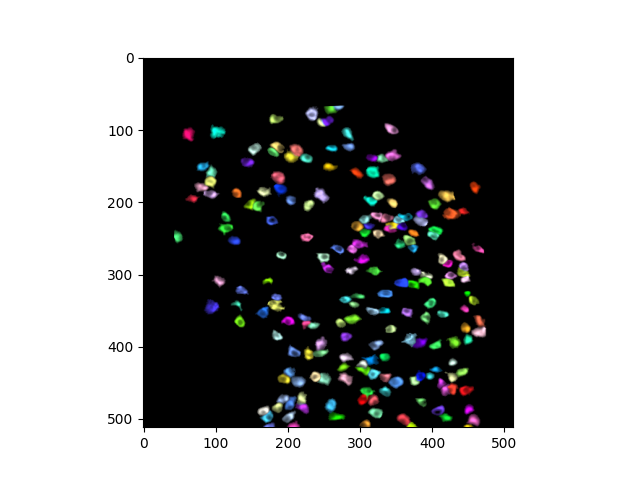

interactive(children=(IntSlider(value=0, description='i_frame', max=15), Output()), _dom_classes=('widget-inte…

In [26]:
%matplotlib notebook
visualization.display_toggle_image_stack(
    FOV_clusters, 
#     interpolation='none', 
#     filternorm=False, 
#     resample=False
)

In [27]:
from bnpm import image_processing

In [28]:
image_processing.prepare_cv2_imshow()

In [34]:
image_processing.play_video_cv2(np.stack(FOV_clusters, axis=0)*255, save_path='/home/rich/Desktop/NY029_rois_forGyu.avi', frameRate=2)

saving to file /home/rich/Desktop/NY029_rois_forGyu.avi


  0%|          | 0/16 [00:00<?, ?it/s]

Video saved
